In [1]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import torch

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.datasets import simulate_3_in_3_out
from gsnn.interpret.GSNNExplainer import GSNNExplainer
from gsnn.interpret.IGExplainer import IGExplainer
from gsnn.interpret.ContrastiveIGExplainer import ContrastiveIGExplainer
from gsnn.interpret.NoiseTunnel import NoiseTunnel
from gsnn.interpret.ContrastiveOcclusionExplainer import ContrastiveOcclusionExplainer
from gsnn.interpret.OcclusionExplainer import OcclusionExplainer
from gsnn.interpret.utils import plot_edge_importance, plot_node_importance
from gsnn.interpret.CounterfactualExplainer import CounterfactualExplainer

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-mds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GSNN Interpretation methods 


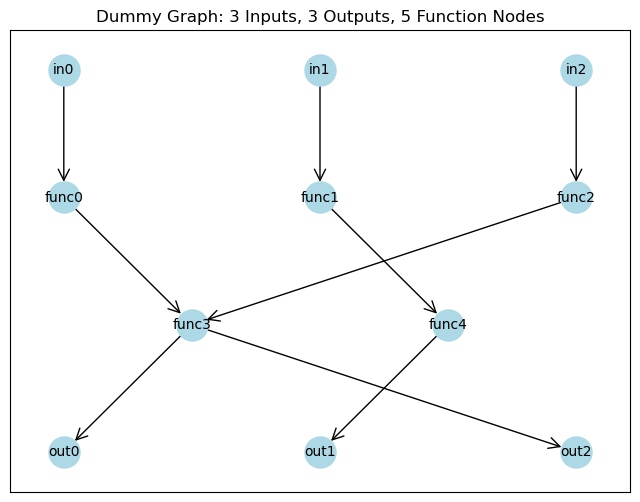

In [2]:
G, pos, x_train, x_test, y_train, y_test, \
    input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=500, 
                                                                    n_test=100, 
                                                                    noise_scale=0.1, 
                                                                    device='cuda')

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=20, 
             layers=2,
             dropout=0.1,
             share_layers=True, 
             bias=False,
             add_function_self_edges=False,
             checkpoint=False, 
             norm='batch', 
             residual=True).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)
crit = torch.nn.MSELoss()

for i in range(1000):
    model.train() 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()
    
    model.eval() 
    with torch.no_grad():
        yhat = model(x_test)
        loss = crit(y_test, yhat)

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

model = model.eval()

n params 11218


## Explanations of *multiple* observations with `GSNNExplainer`


The GSNN explainer method is inspired by GNNExplainer proposed by Ying et. al., however, our approaches diverges slightly in a number of ways:  
 
1. We use MSE rather than mutual information as the optimization objective   
2. We use gumbel-softmax to discretize edge weights [0,1]   
3. We focus on edge explanations rather than node or feature explanations  

```
@misc{ying2019gnnexplainergeneratingexplanationsgraph,
      title={GNNExplainer: Generating Explanations for Graph Neural Networks}, 
      author={Rex Ying and Dylan Bourgeois and Jiaxuan You and Marinka Zitnik and Jure Leskovec},
      year={2019},
      eprint={1903.03894},
      archivePrefix={arXiv},
      primaryClass={cs.LG},
      url={https://arxiv.org/abs/1903.03894}, 
}
```

GSNNExplainer attempts to identify a minimal subgraph that can faithfully reproduce equivalent predictions. This explanation can be used with multiple samples and targets. The resulting edge scores indicate the probability of inclusion: 

$e_i -> 1$ : indicates the edge is important for the prediction   
$e_i -> 0$ : indicates the edge is not important for the prediction   

NOTE: it is important to tune the parameters to ensure faithful predictions. Using too strong of regularization (large beta) can result in unfaithful predictions. We have included a `tune` function to adjust `beta` to a maximum value while maintaining an explained variance threshold (default: 0.7).

BETA TUNING - Starting from User's Beta
Target: Find max beta with R² >= 0.700
Starting beta: 1.0000
Step size: 1.50x

Step 1: Evaluating starting beta = 1.0000
  → R² = -0.0321, Edges = 2
  ✗ Poor performance! Searching downward for better performance...

Trial 1: Testing beta = 0.6667 (direction: down)
  → R² = 0.5909, Edges = 4
  ✗ Still poor, continuing downward...

Trial 2: Testing beta = 0.4444 (direction: down)
  → R² = 1.0000, Edges = 5
  ✓ Performance recovered! Optimal: β=0.4444

TUNING COMPLETE
Starting beta: 1.0000
Optimal beta: 0.4444
Change: 0.44x
Final R²: 1.0000
Selected edges: 5 / 9 (55.6%)


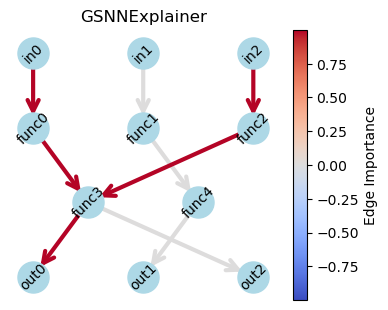

In [4]:
target_ixs = [0]

explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=False, tau0=10, min_tau=0.5, 
                            prior=2, iters=500, lr=1e-2, weight_decay=0, beta=1, verbose=True, 
                            optimizer=torch.optim.Adam, free_edges=0)

# res = explainer.explain(x_train, targets=target_ixs) 
tune_dict = explainer.tune(x_train, targets=target_ixs, min_r2=0.7)
res = tune_dict['edge_df'] 

plot_edge_importance(res, pos, title='GSNNExplainer')


## Optionally choose `node` or `edge` attribution

iter: 499 | loss: 2.9578 | mse: 0.0019 | r2: 0.999 | active nodes: 3 / 11 | entropy: 0.06778
POST-TRAINING EVALUATION (nodes > 0.5)
Selected nodes: 3 / 11 (27.3%)
MSE (subset): 0.000000
R² (subset): 1.0000
Variance explained: 1.0000
Correlation: 1.0000


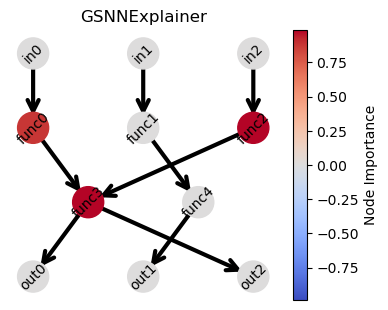

In [15]:
target_ixs = [0]

explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=False, tau0=10, min_tau=0.5, 
                            prior=2, iters=500, lr=1e-2, weight_decay=0, beta=1, verbose=True, 
                            optimizer=torch.optim.Adam, free_edges=0)

res = explainer.explain(x_train, targets=target_ixs, target='node') 

plot_node_importance(res, G, pos, title='GSNNExplainer')

## Explanations of a *single* observation with `Integrated Gradients`

"What latent edge features are responsible for an observations predicted outcome?" 

The returned edge attribution indicates:    
 IGₑ > 0 adding edge e increases predicted value   
 IGₑ < 0 adding edge e decreases predicted value   
 IGₑ ≈ 0 edge e is irrelevant to the predicted value 


In some cases, injecting noise can help provide more robust explanations. More information [here](https://captum.ai/api/noise_tunnel.html). In this example, it is comparable to contrastive_ig. 

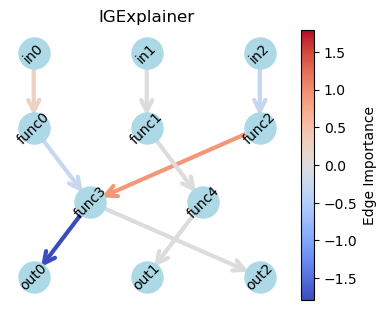

,source,target,score
2,func2,func3,0.911708
3,in0,func0,0.263096
8,func4,out1,0.000000
1,func1,func4,0.000000
4,in1,func1,0.000000
7,func3,out2,0.000000
0,func0,func3,-0.276778
5,in2,func2,-0.298050
6,func3,out0,-1.789540


In [6]:
x = x_train[[0]]
y = y_train[[0]]
target_ixs = [0] 

explainer = NoiseTunnel(IGExplainer(model, data), n_samples=100, noise_std=0.1, agg='mean')

res = explainer.explain(x, target_idx=target_ixs)
res = res.sort_values('score', ascending=False)

plot_edge_importance(res, pos, title='IGExplainer')
res.sort_values('score', ascending=False)

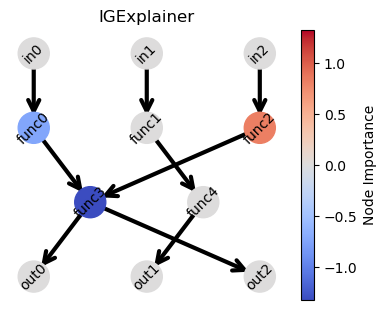

In [19]:
x = x_train[[0]]
y = y_train[[0]]
target_ixs = [0] 

explainer = IGExplainer(model, data)

res = explainer.explain(x, target_idx=target_ixs, target='node')
res = res.sort_values('score', ascending=False)

plot_node_importance(res, G, pos, title='IGExplainer')

## Occlusion Explainer 

y[tidx]-> -1.6586637496948242
yhat[tidx]-> -1.2392131090164185


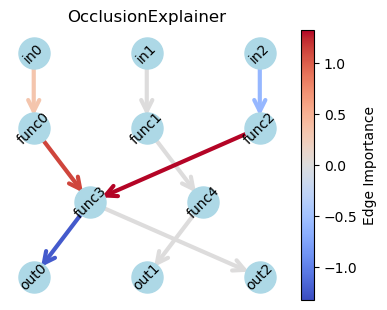

In [20]:
tidx = 0 
x = x_train[[0]]
y = y_train[[0]][:,tidx].item()
yhat = model(x.cuda())[:,tidx].item()
print('y[tidx]->', y)
print('yhat[tidx]->', yhat)

explainer = OcclusionExplainer(model, data, batch_size=64)
res = explainer.explain(x, target_idx=tidx)

plot_edge_importance(res, pos, title='OcclusionExplainer')

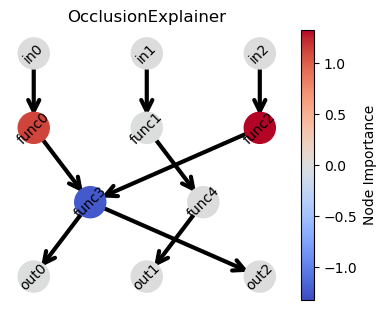

In [21]:
explainer = OcclusionExplainer(model, data, batch_size=64)
res = explainer.explain(x, target_idx=tidx, target='node')

plot_node_importance(res, G, pos, title='OcclusionExplainer')

## Occlusion Explainer tractability can be improved by combining with GSNNExplainer 

For very large graphs, with many edges, occlusion explainer can become intractable. To improve upon this, `GSNNExplainer` can be used to identify a minimal subset of edges that are improtant to performance, and then these edges can be passed to `OcclusionExplainer` to reduce the number of edges to evaluate. 

In [73]:

ge = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=False, tau0=10, min_tau=0.5, 
                            prior=2, iters=500, lr=1e-2, weight_decay=0, beta=1, verbose=True, 
                            optimizer=torch.optim.Adam, free_edges=0)
                            
_, ge_edge_weights = ge.explain(x_train, targets=[tidx], return_weights=True)                                     

res = explainer.explain(x, target_idx=tidx, edge_mask=(ge_edge_weights > 0.5))

res.sort_values('score', ascending=False)

iter: 499 | loss: 3.7269 | mse: 0.7279 | r2: 0.660 | active edges: 3 / 9 | entropy: 0.06496
POST-TRAINING EVALUATION (edges > 0.5)
Selected edges: 3 / 9 (33.3%)
MSE (subset): 0.728245
R² (subset): 0.6595
Variance explained: 0.8027
Correlation: 0.8959


,source,target,score
0,func0,func3,1.579569
3,in0,func0,0.788018
6,func3,out0,-1.004601
1,func1,func4,NaN
2,func2,func3,NaN
4,in1,func1,NaN
5,in2,func2,NaN
7,func3,out2,NaN
8,func4,out1,NaN


## *Contrastive* explanations between two observations 

"What latent edge features are responsible for the difference between two observations predicted outcome?" 

The returned edge attribution indicates:  
 IGₑ > 0 adding edge e enlarges the prediction gap  
 IGₑ < 0 adding edge e shrinks the gap  
 IGₑ ≈ 0 edge e is irrelevant to the gap.  

For this example, we focus on output `out0` and fix `in2` to 5 for both observations, suggesting that the difference in outcome should be explained by the path from `in0`->`func0`->`func3`->`out0`. 

In [74]:
target = 0 

x1 = torch.tensor([[0, 0, 3]], dtype=torch.float32)
x2 = torch.tensor([[-3, 0, 3]], dtype=torch.float32)

yhat1 = model(x1.cuda())[:, target]
yhat2 = model(x2.cuda())[:, target]
delta = yhat1 - yhat2 

print('yhat1', yhat1.item())
print('yhat2', yhat2.item())
print('delta', delta.item())

yhat1 -5.033181190490723
yhat2 -12.176862716674805
delta 7.143681526184082


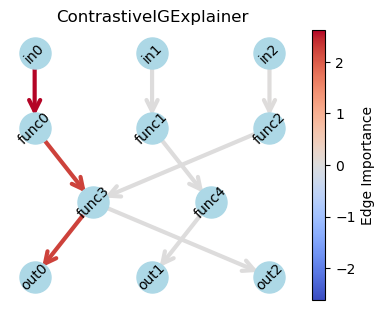

,source,target,score
3,in0,func0,2.615760
0,func0,func3,2.240277
6,func3,out0,2.236099
5,in2,func2,0.034480
2,func2,func3,0.017438
4,in1,func1,0.000000
1,func1,func4,0.000000
7,func3,out2,0.000000
8,func4,out1,0.000000


In [75]:
explainer = ContrastiveIGExplainer(model, data, n_steps=100) 

res = explainer.explain(x1, x2, target_idx=target)  

plot_edge_importance(res, pos, title='ContrastiveIGExplainer')
res.sort_values('score', ascending=False)

## Contrastive Occlusion Explainer 

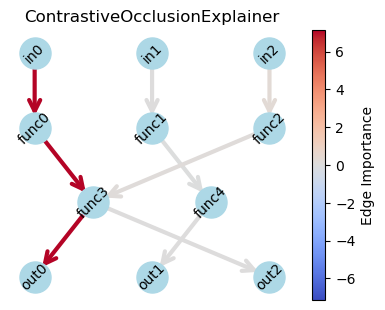

,source,target,score
0,func0,func3,7.143682e+00
6,func3,out0,7.143682e+00
3,in0,func0,7.143681e+00
5,in2,func2,3.272810e-01
2,func2,func3,1.259036e-01
7,func3,out2,4.768372e-07
4,in1,func1,0.000000e+00
8,func4,out1,0.000000e+00
1,func1,func4,-4.768372e-07


In [76]:
explainer = ContrastiveOcclusionExplainer(model, data)

res = explainer.explain(x1, x2, target_idx=target)  

plot_edge_importance(res, pos, title='ContrastiveOcclusionExplainer')
res.sort_values('score', ascending=False)

## Counterfactual explanations 

The goal of this approach will be to understand what minimal changes to inputs (x) can be made to change the predicted outcome to a desired value. This can be used in tandem with contrastive explainers to understand the latent changes involved in the counterfactual response. 

In [77]:
x = x_train[[0]]
y = y_train[[0]]
yhat = model(x.cuda())
target_ixs = [0] 

# summary statistics 
print('y[tidx]->', y[:,target_ixs])
print('yhat[tidx]->', yhat[:,target_ixs]) 
print('x ->', x)
print() 

explainer = CounterfactualExplainer(model, data)

res = explainer.explain(x, 
                        target_value=0.5, 
                        target_idx=target_ixs, 
                        dropout=0.1, 
                        weight_decay=1)

print() 
res

y[tidx]-> tensor([[-1.6587]], device='cuda:0')
yhat[tidx]-> tensor([[-1.0046]], device='cuda:0', grad_fn=<IndexBackward0>)
x -> tensor([[1.7641, 0.4002, 0.9787]], device='cuda:0')

Iteration 492: Loss = 0.870315
Converged at iteration 492
Final loss: 0.870315



,feature,original,perturbation,counterfactual
0,in0,1.764052,-0.625269,1.138783
1,in1,0.400157,0.000000,0.400157
2,in2,0.978738,-0.508059,0.470679


In [78]:
xc = torch.tensor(res.counterfactual.values).view(1, -1) 
cyhat = model(xc.cuda()) 

print('original yhat [tidx] ->', yhat[:,target_ixs].item())
print('counteractual yhat [tidx] ->', cyhat[:,target_ixs].item())

original yhat [tidx] -> -1.0046004056930542
counteractual yhat [tidx] -> -0.47705984115600586


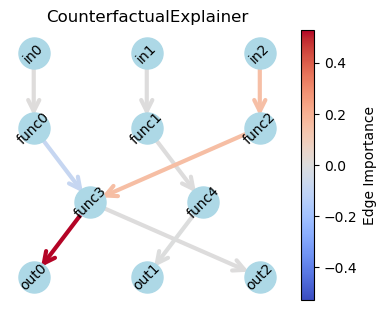

,source,target,score
6,func3,out0,5.275407e-01
2,func2,func3,1.534742e-01
5,in2,func2,1.522183e-01
3,in0,func0,5.335212e-03
1,func1,func4,2.384186e-07
7,func3,out2,0.000000e+00
4,in1,func1,0.000000e+00
8,func4,out1,-1.192093e-07
0,func0,func3,-8.544934e-02


In [79]:
# combine this with a contrastive explainer 

x1 = x 
x2 = xc 

cexplainer = ContrastiveOcclusionExplainer(model, data)

res = cexplainer.explain(x1, x2, target_idx=target_ixs)

plot_edge_importance(res, pos, title='CounterfactualExplainer')
res.sort_values('score', ascending=False)

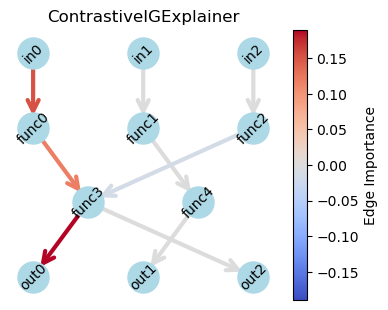

,source,target,score
6,func3,out0,0.189277
3,in0,func0,0.151453
0,func0,func3,0.117998
5,in2,func2,0.001137
1,func1,func4,0.000000
7,func3,out2,0.000000
4,in1,func1,0.000000
8,func4,out1,0.000000
2,func2,func3,-0.013973


In [80]:
explainer = NoiseTunnel(ContrastiveIGExplainer(model, data), n_samples=100, noise_std=0.1, agg='mean')  

res = explainer.explain(x1, x2, target_idx=target_ixs)

plot_edge_importance(res, pos, title='ContrastiveIGExplainer')
res.sort_values('score', ascending=False)